MIT License

Copyright (c) 2019 Alexey Pechnikov, https://orcid.org/0000-0001-9626-8615 (ORCID)

See Linkedin articles

Spectral Coherence between Gravity and Bathymetry Grids

https://www.linkedin.com/pulse/computing-coherence-between-two-dimensional-gravity-grids-pechnikov/

The Density-Depth Model by Spectral Fractal Dimension Index

https://www.linkedin.com/pulse/density-model-spectral-fractal-dimension-index-alexey-pechnikov/

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import linregress

import matplotlib.pyplot as plt
%matplotlib inline

## Console commands to download and prepare datasets

### download Global Multi-Resolution Topography Data Synthesis
curl -o data.topo-mask.hires.tif
    "https://www.gmrt.org/services/GridServer?north=-60&west=-172.5&east=-167.5&south=-62&layer=topo-mask&format=geotiff&resolution=high"

### reproject and crop area
rm -f data.topo-mask.hires.32702.tif &&
    gdalwarp -s_srs WGS84 -t_srs EPSG:32702 -te 444000 3170000 614000 3348000 -tr 500 500 -r bilinear data.topo-mask.hires.tif data.topo-mask.hires.32702.tif

### reproject and crop area from local GEBCO_2019 topography dataset
rm -f GEBCO_2019.subset.32702.tif &&
    gdalwarp -s_srs WGS84 -t_srs EPSG:32702 -te 444000 3170000 614000 3348000 -tr 500 500 -r bilinear GEBCO_2019.nc GEBCO_2019.subset.32702.tif

### reproject and crop area from local Sandwell and Smith Gravity Anomaly dataset
rm -f grav_v27.subset.32702.tif &&
    gdalwarp -s_srs WGS84 -t_srs EPSG:32702 -te 444000 3170000 614000 3348000 -tr 500 500 -r bilinear grav_v27.tif grav_v27.subset.32702.tif

### reproject and crop area from local WGM2012 Free-Air Gravity Anomalies dataset
rm -f WGM2012_Freeair.subset.32702.tif &&
    gdalwarp -s_srs WGS84 -t_srs EPSG:32702 -te 444000 3170000 614000 3348000 -tr 500 500 -r bilinear WGM2012_Freeair_ponc_2min.grd WGM2012_Freeair.subset.32702.tif

### fill NoData by interpolated values
gdal_fillnodata.py GEBCO_2019.subset.32702.tif GEBCO_2019.subset.32702.fixed.tif

gdal_fillnodata.py grav_v27.subset.32702.tif grav_v27.subset.32702.fixed.tif

gdal_fillnodata.py WGM2012_Freeair.subset.32702.tif WGM2012_Freeair.subset.32702.fixed.tif

## Define functions

In [2]:
# band filter
def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1) - gaussian_filter(raster.values,g2)
    return raster

def spectrum(raster, gammas):
    rasters = []
    for g in gammas:
        print (g,". ", end = '')
        _raster = raster_filter_range(raster, g-.5, g+.5)
        rasters.append(_raster)
    return rasters

def correlogram(rasters1, rasters2, gammas):
    corrs = []
    for ridx in range(len(gammas)):
        print (ridx+1,". ", end = '')
        _raster2 = rasters2[ridx]
        for didx in range(len(gammas)):
            _raster1 = rasters1[didx]
            df = pd.DataFrame({'r1': _raster1.values.flatten(), 'r2': _raster2.values.flatten()})
            corr = round((df.corr()).iloc[0,1],2)
            corrs.append(corr)

    da_corr = xr.DataArray(np.array(corrs).reshape([len(gammas),len(gammas)]),
                          coords=[resolution*gammas,resolution*gammas],
                          dims=['r2','r1'])

    return da_corr

## Define parameters

In [3]:
# rasters below defined in projected coordinates system (EPSG:32702)
GEBCO="GEBCO_2019.subset.32702.fixed.tif"
GMRT="data.topo-mask.hires.32702.tif"
GRAVITY="grav_v27.subset.32702.fixed.tif"
FREEAIR="WGM2012_Freeair.subset.32702.fixed.tif"

# scale coefficient for rasters [km/pixel]
resolution = 0.5
# waveband in resolution units
GAMMA = 100
# waveband processing step
DGAMMA= 1

## Define discrete spectrum

In [4]:
gammas = np.arange(DGAMMA,GAMMA+DGAMMA/2,DGAMMA)

## Load rasters

### GEBCO_2019 topography

In [5]:
dem = xr.open_rasterio(GEBCO).rename({'x':'lon','y':'lat'})
dem

<xarray.DataArray (band: 1, lat: 356, lon: 340)>
[121040 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * lat      (lat) float64 3.348e+06 3.347e+06 3.347e+06 ... 3.171e+06 3.17e+06
  * lon      (lon) float64 4.442e+05 4.448e+05 4.452e+05 ... 6.132e+05 6.138e+05
Attributes:
    transform:   (500.0, 0.0, 444000.0, 0.0, -500.0, 3348000.0)
    crs:         +init=epsg:32702
    res:         (500.0, 500.0)
    is_tiled:    0
    nodatavals:  (9.969209968386869e+36,)

## Global Multi-Resolution Topography Data Synthesis

In [6]:
gmt = xr.open_rasterio(GMRT).rename({'x':'lon','y':'lat'})
# fix required
gmt.values[gmt.values==0] = np.nan
gmt

<xarray.DataArray (band: 1, lat: 356, lon: 340)>
array([[[-4194.353 , -4248.9688, ...,        nan,        nan],
        [-4241.5127, -4289.2285, ...,        nan,        nan],
        ...,
        [       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan]]], dtype=float32)
Coordinates:
  * band     (band) int64 1
  * lat      (lat) float64 3.348e+06 3.347e+06 3.347e+06 ... 3.171e+06 3.17e+06
  * lon      (lon) float64 4.442e+05 4.448e+05 4.452e+05 ... 6.132e+05 6.138e+05
Attributes:
    transform:   (500.0, 0.0, 444000.0, 0.0, -500.0, 3348000.0)
    crs:         +init=epsg:32702
    res:         (500.0, 500.0)
    is_tiled:    0
    nodatavals:  (nan,)

### WGM2012 Free-Air Gravity Anomalies

In [7]:
frr = xr.open_rasterio(FREEAIR).rename({'x':'lon','y':'lat'})
frr

<xarray.DataArray (band: 1, lat: 356, lon: 340)>
[121040 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * lat      (lat) float64 3.348e+06 3.347e+06 3.347e+06 ... 3.171e+06 3.17e+06
  * lon      (lon) float64 4.442e+05 4.448e+05 4.452e+05 ... 6.132e+05 6.138e+05
Attributes:
    transform:   (500.0, 0.0, 444000.0, 0.0, -500.0, 3348000.0)
    crs:         +init=epsg:32702
    res:         (500.0, 500.0)
    is_tiled:    0
    nodatavals:  (nan,)

### Sandwell and Smith Gravity Anomaly

In [8]:
grv = xr.open_rasterio(GRAVITY).rename({'x':'lon','y':'lat'})
grv

<xarray.DataArray (band: 1, lat: 356, lon: 340)>
[121040 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * lat      (lat) float64 3.348e+06 3.347e+06 3.347e+06 ... 3.171e+06 3.17e+06
  * lon      (lon) float64 4.442e+05 4.448e+05 4.452e+05 ... 6.132e+05 6.138e+05
Attributes:
    transform:   (500.0, 0.0, 444000.0, 0.0, -500.0, 3348000.0)
    crs:         +init=epsg:32702
    res:         (500.0, 500.0)
    is_tiled:    0
    nodatavals:  (nan,)

## Plot datasets

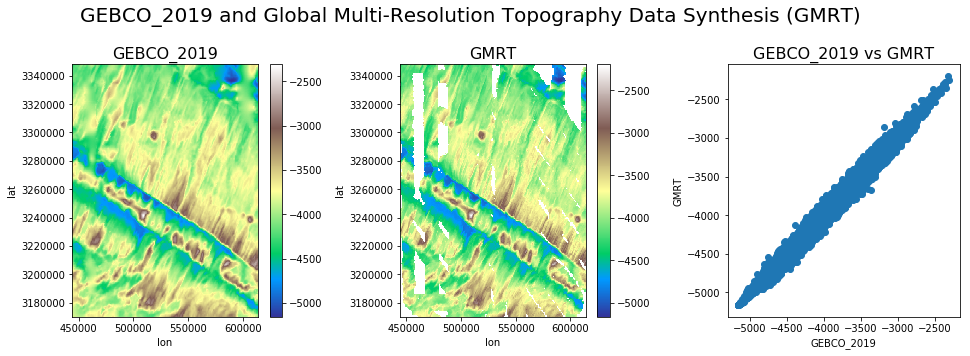

In [9]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(14,5))

dem.plot(ax=ax1, cmap='terrain')
ax1.set_title('GEBCO_2019',fontsize=16)

gmt.plot(ax=ax2, cmap='terrain')
ax2.set_title('GMRT',fontsize=16)

ax3.scatter(dem.values, gmt.values,cmap='terrain')
ax3.set_title('GEBCO_2019 vs GMRT',fontsize=16)
ax3.set_xlabel('GEBCO_2019')
ax3.set_ylabel('GMRT')

fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.suptitle('GEBCO_2019 and Global Multi-Resolution Topography Data Synthesis (GMRT)',fontsize=20)
#plt.savefig('GEBCO_2019 and Global Multi-Resolution Topography Data Synthesis (GMRT).jpg', dpi=150)
plt.show()

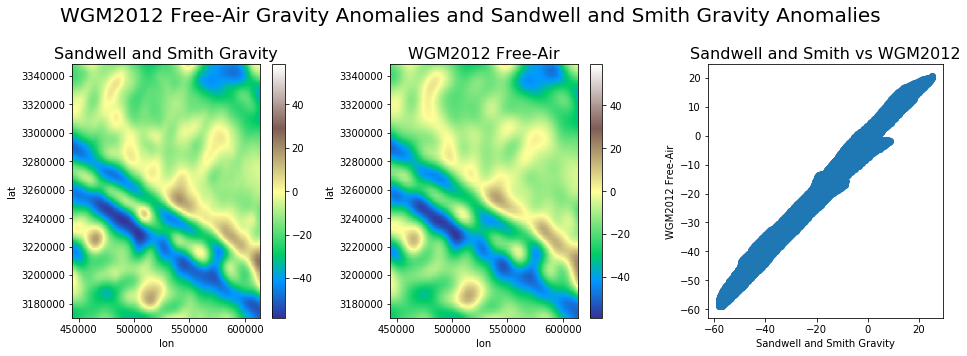

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,5))

grv.plot(ax=ax1, cmap='terrain')
ax1.set_title('Sandwell and Smith Gravity',fontsize=16)

frr.plot(ax=ax2, cmap='terrain')
ax2.set_title('WGM2012 Free-Air',fontsize=16)

ax3.scatter(grv.values, frr.values,cmap='terrain')
ax3.set_title('Sandwell and Smith vs WGM2012',fontsize=16)
ax3.set_xlabel('Sandwell and Smith Gravity')
ax3.set_ylabel('WGM2012 Free-Air')

fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.suptitle('WGM2012 Free-Air Gravity Anomalies and Sandwell and Smith Gravity Anomalies',fontsize=20)
#plt.savefig('WGM2012 Free-Air Gravity Anomalies and Sandwell and Smith Gravity Anomalies.jpg', dpi=150)
plt.show()

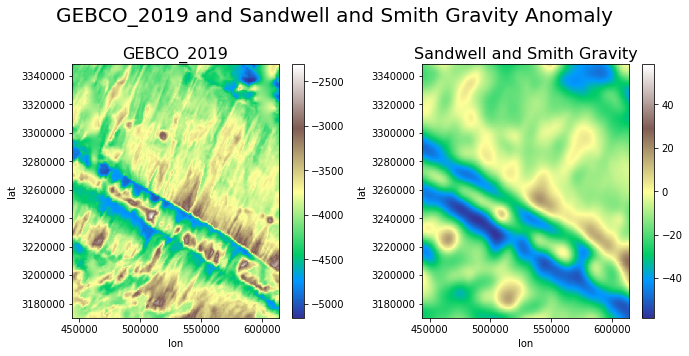

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

dem.plot(ax=ax1, cmap='terrain')
ax1.set_title('GEBCO_2019',fontsize=16)

grv.plot(ax=ax2, cmap='terrain')
ax2.set_title('Sandwell and Smith Gravity',fontsize=16)

fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.suptitle('GEBCO_2019 and Sandwell and Smith Gravity Anomaly',fontsize=20)
#plt.savefig('GEBCO_2019 and Sandwell and Smith Gravity Anomaly.jpg', dpi=150)
plt.show()


## Spectrums calculation

In [ ]:
dems = spectrum(dem, gammas)
grvs = spectrum(grv, gammas)

1.0 . 2.0 . 3.0 . 4.0 . 5.0 . 6.0 . 7.0 . 8.0 . 9.0 . 10.0 . 11.0 . 12.0 . 13.0 . 14.0 . 15.0 . 16.0 . 17.0 . 18.0 . 19.0 . 20.0 . 21.0 . 22.0 . 23.0 . 24.0 . 25.0 . 26.0 . 27.0 . 28.0 . 29.0 . 30.0 . 31.0 . 32.0 . 33.0 . 34.0 . 35.0 . 36.0 . 37.0 . 38.0 . 39.0 . 40.0 . 41.0 . 42.0 . 43.0 . 44.0 . 45.0 . 46.0 . 47.0 . 48.0 . 49.0 . 50.0 . 51.0 . 52.0 . 53.0 . 54.0 . 55.0 . 56.0 . 57.0 . 58.0 . 59.0 . 60.0 . 61.0 . 

## Correlogram calculation

In [ ]:
da_grv_corr = correlogram(dems, grvs, gammas)

In [ ]:
float(da_grv_corr.min()),float(da_grv_corr.max())

## Plot correlogram

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.5,5))

da_grv_corr.plot(cmap='RdBu_r',ax=ax1, vmin=-1,vmax=1)
contours = da_grv_corr.plot.contour(levels=[.5,.75],colors=['gray','lightgray'],linestyles='--',ax=ax1)
ax1.clabel(contours, contours.levels, inline=True, fmt='%r', colors=['gainsboro','white'], fontsize=14)
ax1.set_xlabel('GEBCO_2019 Wavelength, km',fontsize=12)
ax1.set_ylabel('Gravity Wavelength, km',fontsize=12)
ax1.set_title('Correlogram',fontsize=16)

ax2.plot(resolution*gammas, [float(da_grv_corr[g,g]) for g in range(len(gammas))])
ax2.set_xlabel('Wavelength, km',fontsize=12)
ax2.set_ylabel('Coherence',fontsize=12)
ax2.set_yticks([0,0.5,1])
ax2.yaxis.grid(True)
ax2.set_xlim([resolution*GAMMA,0])
ax2.set_title('Radial coherence',fontsize=16)

plt.suptitle('Pearson Correlation Coefficient:\nGEBCO_2019 vs Sandwell and Smith Gravity Anomaly',fontsize=20)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.85])
#plt.savefig('Pearson Correlation Coefficient: GEBCO_2019 vs Sandwell and Smith Gravity Anomaly.jpg', dpi=150)
plt.show()

## Fractal Dimension Index calculation

In [ ]:
dem_stds = [_.std() for _ in dems]
grv_stds = [_.std() for _ in grvs]

In [ ]:
slope = np.diff(np.log10(dem_stds))/np.diff(np.log10(resolution*gammas))
dem_fractality = (3 - (slope/2))

slope = np.diff(np.log10(grv_stds))/np.diff(np.log10(resolution*gammas))
grv_fractality = (3 - (slope/2))

In [ ]:
# define real depth
depths = 0.707*resolution*(gammas[1:] - DGAMMA/2)
depths_seafloor = -float(dem.mean())/1000+depths

## Density Model by Fractal Dimension Index

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10.5,5))

ax.plot(depths_seafloor, 1000*dem_fractality, c='black', label='GEBCO_2019')
#ax.plot(depths, 1000*grv_fractality, c='gray', linestyle=':',
#        label='Sandwell and Smith Gravity (biased estimator)')
ax.plot(depths_seafloor, 1000*grv_fractality, c='red',
        label='Sandwell and Smith Gravity (translated to seafloor)')
ax.set_xlim([0,0.707*resolution*GAMMA])
ax.legend(loc='lower center', fontsize=16)
ax.set_xlabel('Depth, km',fontsize=12)
ax.set_ylabel('Density, kg/m³',fontsize=12)
ax.invert_yaxis()
#ax.grid()

ax.axvline(x=-dem.mean()/1000, ymin=0, ymax=1, color = 'darkgreen', ls='dotted')
ax.text(-0.8-dem.mean()/1000, (ax.get_ylim()[0]+ax.get_ylim()[1])/2,
        "Seafloor", rotation=90, verticalalignment='center',fontsize=16)
ax.text(3.25, 4475, "3.9", color="darkgreen", fontsize=14)
ax.axhline(y=1000*dem_fractality[0], xmin=0, xmax=.12, color = 'darkgreen', ls='--')
ax.text(-2.2, 1000*dem_fractality[0], int(np.round(1000*dem_fractality[0])), color="darkgreen", fontsize=14)

ax.fill_between(depths_seafloor, 1000*dem_fractality, 1000*grv_fractality,
                facecolor='red', alpha=.05, interpolate=True)

ax.annotate("Biased estimator due to upward continuation of gravity",
            xy=(.27, 0.49), xytext=(.3, 0.6), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="->"), fontsize=14)

ax.annotate("~3.9 km wavelength difference equal to ~2.76 km depth difference",
            xy=(.125, 0.76), xytext=(.195, 0.75), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="<->"), fontsize=14)

plt.suptitle('The Density-Depth Model by Spectral Fractal Dimension Index',fontsize=20)
plt.title('Seafloor Density %d kg/m³' % int(np.round(1000*dem_fractality[0])),fontsize=16)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.savefig('Density Model by Fractal Dimension Index.jpg', dpi=150)
plt.show()